<a href="https://colab.research.google.com/github/nebulous05/influence-functions-pytorch/blob/main/attempt5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [2]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ],
    )
train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set = datasets.MNIST("./data", train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38358329.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2527609.68it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13245865.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3930375.24it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
random.seed(42)
# take subsets of train/test set to speed up runtime
train_indices = random.sample(range(len(train_set)), 10000)
test_indices = random.sample(range(len(test_set)), 100)

train_subset = Subset(train_set, train_indices)
test_subset = Subset(test_set, test_indices)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=100, shuffle=False)

In [4]:
# some functions to retrieve/view data
def get_item(index, dataset='train'):
    ''' returns a pair (image_tensor, label_int) '''
    if dataset == 'train':
        return train_subset[index]
    elif dataset == 'test':
        return test_subset[index]

def show_image(index, dataset='train'):
    ''' show an image with matplotlib '''
    if dataset == 'train':
        img = train_subset[index][0].numpy().reshape(28, 28)
    elif dataset == 'test':
        img = test_subset[index][0].numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [5]:
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(784, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.linear(x)

def train_mnist_lr(dataloader, seed, epochs):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = LogReg()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        print("Epoch " + str(epoch) + " loss: " + str(epoch_loss / len(dataloader)))

    return model

In [6]:
model = train_mnist_lr(train_loader, 42, 20)

Epoch 0 loss: 1.9264041543006898
Epoch 1 loss: 1.3512792348861695
Epoch 2 loss: 1.081665849685669
Epoch 3 loss: 0.928858506679535
Epoch 4 loss: 0.83067786693573
Epoch 5 loss: 0.7620778501033783
Epoch 6 loss: 0.7112449944019318
Epoch 7 loss: 0.6719158351421356
Epoch 8 loss: 0.6404694080352783
Epoch 9 loss: 0.6146686613559723
Epoch 10 loss: 0.593056857585907
Epoch 11 loss: 0.5746440947055816
Epoch 12 loss: 0.5587335228919983
Epoch 13 loss: 0.5448199689388276
Epoch 14 loss: 0.5325279772281647
Epoch 15 loss: 0.5215720772743225
Epoch 16 loss: 0.5117315530776978
Epoch 17 loss: 0.5028326749801636
Epoch 18 loss: 0.4947367489337921
Epoch 19 loss: 0.4873316675424576


In [7]:
wrongly_classified_indices = []

model.eval()
num_correct = 0
for i in range(len(test_subset)):
    input, label = test_subset[i]
    output = model(input)
    if torch.argmax(output) != label:
        wrongly_classified_indices.append(i)
    else:
      num_correct += 1
print("Test set accuracy: " + str(num_correct / len(test_subset)) + " (" + str(num_correct) + "/" + str(len(test_subset)) + ")")

Test set accuracy: 0.91 (91/100)


z_label: 9
prediction: tensor(7)


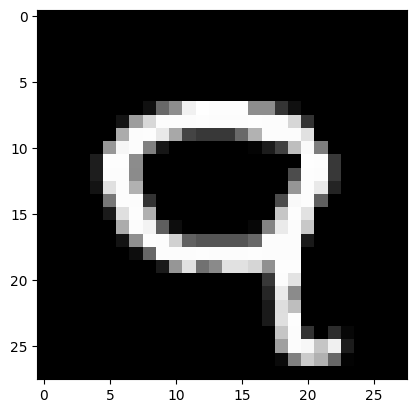

In [11]:
random.seed(42)
model.eval()
z_idx = wrongly_classified_indices[random.randint(0, len(wrongly_classified_indices)-1)]
z_input, z_label = test_subset[z_idx]
prediction = torch.argmax(model(z_input))
print("z_label: " + str(z_label))
print("prediction: " + str(prediction))
show_image(z_idx, dataset='test')

In [20]:
def compute_gradient(my_model, input, label):
    ''' returns a Tensor representing the gradient of the loss
        wrt the model parameters (7840)'''
    my_model.eval()
    output = my_model(input)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output, torch.tensor([label], dtype=torch.long))
    grad_vector = torch.autograd.grad(loss, my_model.parameters(), create_graph=True)
    return grad_vector[0].view(-1)

def compute_hvp(my_model, input, label, v):
    grad = compute_gradient(my_model, input, label)
    grad_v_product = torch.dot(grad, v)
    hvp = torch.autograd.grad(grad_v_product, my_model.parameters(), retain_graph=True)
    return hvp[0].view(-1)

def compute_s_test(my_model, training_set, z_input, z_label, recursion_depth=1000,
                   num_repeats=10, scale=100, damp=0.01):
    my_model.eval()
    v = compute_gradient(model, z_input, z_label) # shape==[7840]
    s_test = None

    for i in range(num_repeats):
        print("Repeat " + str(i))
        cur_estimate = v.clone()
        for j in range(recursion_depth):
            train_idx = random.randint(0, len(training_set)-1)
            input, label = training_set[train_idx]

            hvp = compute_hvp(my_model, input, label, cur_estimate)
            hvp = hvp.detach()

            cur_estimate = v + (1 - damp) * cur_estimate - hvp / scale

            cur_estimate = cur_estimate.detach()

            if j % 100 == 0:
              print("Iteration " + str(j))
              print("Norm of cur_estimate: " + str(torch.norm(cur_estimate)))

        if s_test is None:
            s_test = cur_estimate / scale
        else:
            s_test += (cur_estimate / scale)

    return s_test / num_repeats

In [21]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
s_test = compute_s_test(model, train_subset, z_input, z_label)

Repeat 0
Iteration 0
Norm of cur_estimate: tensor(58.5807)
Iteration 100
Norm of cur_estimate: tensor(1605.7977)
Iteration 200
Norm of cur_estimate: tensor(2036.2773)
Iteration 300
Norm of cur_estimate: tensor(2238.8843)
Iteration 400
Norm of cur_estimate: tensor(2245.0750)
Iteration 500
Norm of cur_estimate: tensor(1893.2063)
Iteration 600
Norm of cur_estimate: tensor(2206.6213)
Iteration 700
Norm of cur_estimate: tensor(2238.3320)
Iteration 800
Norm of cur_estimate: tensor(2272.7551)
Iteration 900
Norm of cur_estimate: tensor(2073.0115)
Repeat 1
Iteration 0
Norm of cur_estimate: tensor(58.6831)
Iteration 100
Norm of cur_estimate: tensor(1535.1434)
Iteration 200
Norm of cur_estimate: tensor(1997.2250)
Iteration 300
Norm of cur_estimate: tensor(2074.8386)
Iteration 400
Norm of cur_estimate: tensor(1900.1631)
Iteration 500
Norm of cur_estimate: tensor(2084.7068)
Iteration 600
Norm of cur_estimate: tensor(1969.6156)
Iteration 700
Norm of cur_estimate: tensor(2118.3206)
Iteration 800
Norm

In [22]:
def compute_influence(my_model, training_set, s_test):
    my_model.eval()
    influence_scores = {}
    for i in range(len(training_set)):
        input, label = training_set[i]
        grads = compute_gradient(model, input, label)
        influence_scores[i] = -1 * (torch.dot(grads, s_test).item())
    return influence_scores

influence_scores = compute_influence(model, train_subset, s_test)

In [23]:
def select_top_influential_points(influence_scores, top_n=500):
    # Sort the dictionary by the absolute value of the influence scores in descending order
    sorted_influences = sorted(influence_scores.items(), key=lambda item: abs(item[1]), reverse=True)

    # Select the top N most influential points
    top_influential_dict = dict(sorted_influences[:top_n])

    return top_influential_dict

top_influential_dict = select_top_influential_points(influence_scores, 50)
print(top_influential_dict)

{5967: -341.27545166015625, 7603: -298.6144714355469, 2447: -256.7047119140625, 3708: -236.0272674560547, 7382: -233.33685302734375, 9497: -229.86166381835938, 5013: -229.18020629882812, 6524: -224.89715576171875, 1078: -221.08145141601562, 8674: -212.8681182861328, 2848: -198.59710693359375, 7111: -193.3084716796875, 1306: -189.207275390625, 348: -179.60508728027344, 7610: -177.8206787109375, 6815: -177.52268981933594, 1388: -171.8701171875, 5535: -170.36119079589844, 2912: -168.1494140625, 1215: -167.17530822753906, 5360: -163.7813720703125, 9569: -158.24014282226562, 1345: -151.54605102539062, 215: -145.5293426513672, 9337: -144.87228393554688, 1390: -140.00692749023438, 8922: -135.49374389648438, 6945: -129.4011688232422, 9048: -128.9105224609375, 8356: -123.71358489990234, 6163: -123.68424987792969, 8338: -120.88836669921875, 8698: -116.91468811035156, 8666: -112.71609497070312, 3024: 110.97483825683594, 6267: -109.35186767578125, 8305: 107.69244384765625, 7877: -105.6342849731445

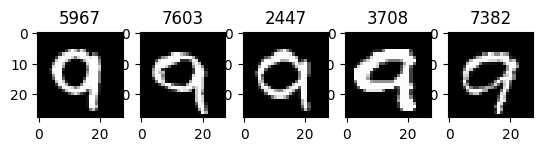

In [24]:
def show_images(indices, num):
    ''' show an image with matplotlib '''
    fig, axs = plt.subplots(1, num);
    imgs = []
    for i in range(num):
      imgs.append(train_subset[indices[i]][0].numpy().reshape(28, 28))
    for i in range(num):
      axs[i].imshow(imgs[i], cmap='gray')
      axs[i].set_title(str(indices[i]))

show_images(list(top_influential_dict.keys()), 5)

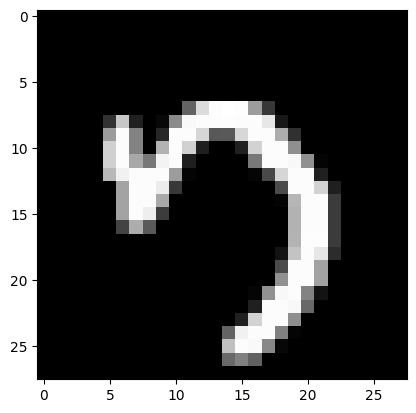

In [25]:
show_image(3024)

In [43]:
torch.save(model.state_dict(), 'model_params.pth')

In [46]:
def verify_influence_score(idx, epochs):
  torch.manual_seed(42)
  np.random.seed(42)
  random.seed(42)

  model.eval()
  loss_fn = nn.CrossEntropyLoss()
  initial_loss = loss_fn(model(z_input), torch.tensor([z_label])).item()

  new_model = LogReg()
  new_model.load_state_dict(torch.load('model_params.pth'))
  new_model.eval()

  new_subset = Subset(train_subset, [i for i in range(len(train_subset)) if i != idx])
  new_loader = DataLoader(new_subset, batch_size=64, shuffle=True)
  new_optimizer = optim.SGD(new_model.parameters(), lr=0.0001, weight_decay=0.01)

  for epoch in range(epochs):
    new_model.train()
    for inputs, labels in new_loader:
      new_optimizer.zero_grad()
      outputs = new_model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      new_optimizer.step()
    new_model.eval()
    curr_loss = loss_fn(new_model(z_input), torch.tensor([z_label])).item()
    print("Epoch " + str(epoch) + " new - old: " + str(curr_loss - initial_loss))

  new_loss = loss_fn(new_model(z_input), torch.tensor([z_label])).item()

  print("Initial loss: " + str(initial_loss))
  print("New loss: " + str(new_loss))
  return new_loss - initial_loss

In [48]:
ret = verify_influence_score(5967, 10) # [0.001]

<ipython-input-46-b7a72020fa7b>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('model_params.pth'))


Epoch 0 new - old: -2.9802322387695312e-05
Epoch 1 new - old: -0.001232147216796875
Epoch 2 new - old: -0.0047206878662109375
Epoch 3 new - old: -0.006493806838989258
Epoch 4 new - old: -0.008824348449707031
Epoch 5 new - old: -0.010685205459594727
Epoch 6 new - old: -0.012551069259643555
Epoch 7 new - old: -0.014585256576538086
Epoch 8 new - old: -0.01703500747680664
Epoch 9 new - old: -0.018017292022705078
Initial loss: 2.077019453048706
New loss: 2.059002161026001


In [27]:
!git clone https://github.com/TRAIS-Lab/dattri

Cloning into 'dattri'...
remote: Enumerating objects: 1853, done.
remote: Counting objects: 100% (723/723), done.
remote: Compressing objects: 100% (530/530), done.
remote: Total 1853 (delta 469), reused 193 (delta 193), pack-reused 1130 (from 1)
Receiving objects: 100% (1853/1853), 3.78 MiB | 14.19 MiB/s, done.
Resolving deltas: 100% (939/939), done.


In [28]:
%cd dattri

/content/dattri


In [29]:
!pip install -e .

Obtaining file:///content/dattri
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dattri (pyproject.toml) ... done
  Created wheel for dattri: filename=dattri-0.0.1.dev0-0.editable-py3-none-any.whl size=8070 sha256=597a396be54baf2cea73c866e7f3b7426449cb3e9ab56ab2479c5c1f9244ab29
  Stored in directory: /tmp/pip-ephem-wheel-cache-86i_aagl/wheels/11/81/48/6368c1bdb7b3c8f78e7ff6b69997b067b0c1d7454a72265ece
Successfully built dattri


In [30]:
from dattri.algorithm import IFAttributorCG
from dattri.task import AttributionTask

In [31]:
def f(params, data_target_pair):
    x, y = data_target_pair
    loss = nn.CrossEntropyLoss()
    yhat = torch.func.functional_call(model, params, x)
    return loss(yhat, y)

task = AttributionTask(loss_func=f,
                       model=model,
                       checkpoints=model.state_dict())

attributor = IFAttributorCG(
    task=task,
    max_iter=10,
    regularization=1e-2
)

attributor.cache(train_loader)
with torch.no_grad():
    score = attributor.attribute(train_loader, test_loader)

calculating gradient of test set...: 100%|██████████| 1/1 [00:18<00:00, 18.59s/it]


In [32]:
print(z_idx)
print(score.shape)

26
torch.Size([10000, 100])


In [33]:
# show the 7th col of score
actual_scores = score[:, 26]

In [34]:
print(actual_scores.shape)

torch.Size([10000])


In [35]:
actual_influence = {}
for i in range(len(train_subset)):
  actual_influence[i] = actual_scores[i].item()

In [37]:
print(actual_influence[3024])

-5266.9140625


In [38]:
print(actual_influence[5967])

21765.646484375


In [39]:
print(actual_influence[7603])

22016.12890625


In [40]:
print(actual_influence[2447])

12532.810546875
